In [172]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings

# Lattice

In [173]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

def match_tunes(madx,qx,qy):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    GLOBAL, Q2={qy},Q1={qx};
    vary, name=qd_k1, step=0.0000001;
    vary, name=qf_k1, step=0.0000001;
    simplex, calls=5000, tolerance=1E-10;
    endmatch;''')
    qf = madx.eval('qf_k1')
    qd = madx.eval('qd_k1')
    return qf,qd

def match_disp(madx):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    constraint, sequence=he_ring, range = "qf2b", DX=0.0;
    vary, name=qb_k1, step=0.0000001;
    jacobian, calls=5000, tolerance=1E-10;
    endmatch;''')
    qb = madx.eval('qb_k1') 
    return qb

print("Matched to Qx 2.4, Qy 1.2 with quadrupole strengths qf, qd = ", match_tunes(mad, 2.4, 1.2))

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw0 = line.twiss4d()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.01.15 15:31:41      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 425.27it/s]


Qx =  2.3999998874588675 , Qy =  1.2000022673265172


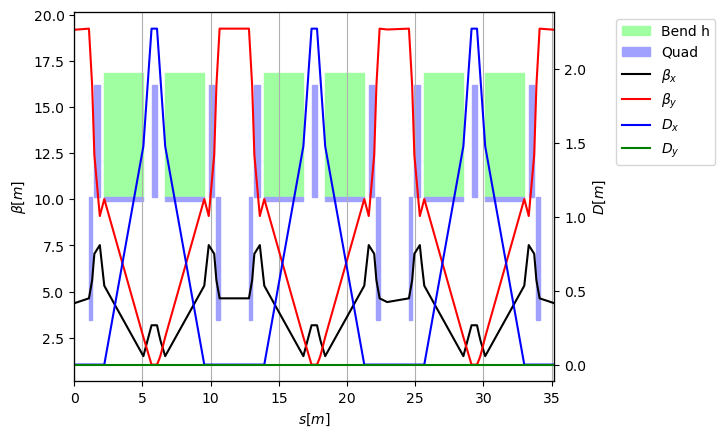

In [174]:
tw0.plot()
plt.savefig("figures/HeLICS_lattice.png", dpi=300)
print("Qx = ", tw0.qx, ", Qy = ", tw0.qy)

# Dipole magnet

In [175]:
############################
# Magnet design parameters #
############################

rho = 2.737
phi = 60/180*np.pi
theta_E = 30/180*np.pi
l_magn = rho*phi
gap = 0.07

dipole_k0 = 1/rho
dipole_k1 = -0.11

In [176]:
def heaviside_tol(x, tol=1e-10, h0=0.5):
    """Heaviside step function with numerical tolerance for central value"""
    x = np.asarray(x)
    res = np.zeros_like(x, dtype=float)
    res[x > tol] = 1.0
    res[np.abs(x) <= tol] = h0  # value at the "center"
    return res

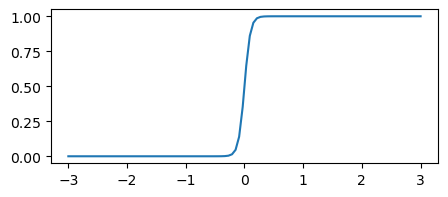

In [177]:
# Entrance fringe 
def b1shape(b1, a, s):
    return b1/2 * (np.tanh(s/a) + 1)

ss = np.linspace(-3, 3, 100)
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(ss, b1shape(1, 0.1, ss))

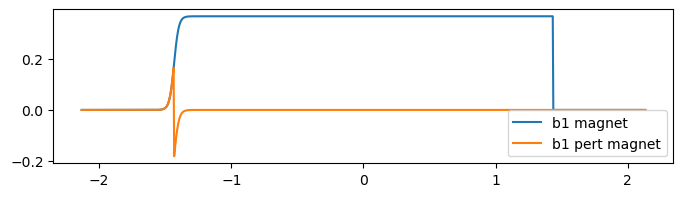

In [178]:
####################################
# Perturbing fields for one dipole #
####################################

def b1_half(s):
    """Return the fitted b1 value at longitudinal position s."""
    b1val = 1/rho
    a=gap/2
    b1_vals = np.array([b1shape(b1val, a, ss+l_magn/2) if ss > -l_magn/2-5*gap else 0 for ss in s])
    return b1_vals

def b1_magnet(s):
    #return np.where(s<0, b1_half(s), b1_half(-s))
    return np.where(s<0, b1_half(s), heaviside_tol(-s+l_magn/2) * dipole_k0)

def hs_magnet(s):
    return (heaviside_tol(s+l_magn/2) - heaviside_tol(s-l_magn/2)) * dipole_k0

def b1_pert_magnet(s):
    return b1_magnet(s) - hs_magnet(s)

ss = np.linspace(-l_magn/2 - 10*gap, l_magn/2 + 10*gap, 1000)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(ss, b1_magnet(ss), label='b1 magnet')
ax.plot(ss, b1_pert_magnet(ss), label='b1 pert magnet')
ax.legend()

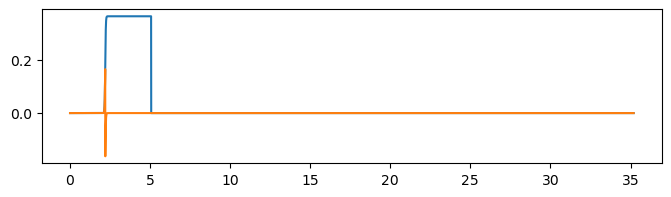

In [179]:
####################################
# Perturbing fields for whole ring #
####################################

tab = line.get_table()
dipole_centers = tab['s_center'][tab["element_type"] == 'Bend']
dc0 = dipole_centers[0]

def b1_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    # for dc in dipole_centers:
    #     total += b1_magnet(s - dc)
    total += b1_magnet(s - dc0)  # Temporary: only one dipole
    return total

def hs_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    # for dc in dipole_centers:
    #     total += hs_magnet(s - dc)
    total += hs_magnet(s - dc0)  # Temporary: only one dipole
    return total

def b1_pert_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    # for dc in dipole_centers:
    #     total += b1_pert_magnet(s - dc)
    total += b1_pert_magnet(s - dc0)  # Temporary: only one dipole
    return total
ss = np.linspace(0, line.get_length(), 5000)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(ss, b1_ring(ss), label='Full dipole model')
ax.plot(ss, b1_pert_ring(ss), label='Perturbation model')

# Resonance driving terms with combined function dipole fringes

In [180]:
########################################################
# Resonance driving terms from hamiltonian terms hpqrt #
########################################################

def f(h_func, p, q, r, t, s, mux, muy, tw):
    """
    Resonance driving term f(s) at an observation position s, corresponding to phase advances mux, muy.
    """
    # Ensure arrays
    s = np.asarray(s)
    mux = np.asarray(mux)
    muy = np.asarray(muy)
    
    # Common factors
    base = h_func(p,q,r,t, tw.s, tw.alfx, tw.alfy, tw.betx, tw.bety) / (1 - np.exp(2 * np.pi * 1j * ((p-q)*tw.qx+(r-t)*tw.qy)))

    # Exponent term depends on each mux value
    exp_term = np.exp(1j * 2*np.pi* ((p-q)*(mux[None, :] - tw.mux[:, None]   # Observation - source
                                            + tw.qx*((mux[None, :] - tw.mux[:, None]) < 0))
                                     + (r-t)*(muy[None, :] - tw.muy[:, None]
                                            + tw.qy*((muy[None, :] - tw.muy[:, None]) < 0))
                                     ))  # shape (len(tw.s), len(mux))

    # Integrand for each mux value → integrate along tw.s
    integrand = base[:, None] * exp_term

    # Integrate along s for each mux
    vals = np.trapezoid(integrand, x=tw.s, axis=0)

    return vals

In [181]:
###################
# Field expansion #
###################

s = sp.symbols("s")
hs = sp.symbols("hs")
b1 = sp.Function("b1")(s)
b2 = sp.Function("b2")(s)
b3 = sp.Function("b3")(s)

dip_straight = bpmeth.FieldExpansion(b=(b1, ))
dip_curved = bpmeth.FieldExpansion(b=(b1, ), hs=hs)


#################
# Symbolic RDTs #
#################

order = 3
betx, bety, alphx, alphy = sp.symbols("beta_x beta_y alpha_x alpha_y")
h_dip_straight = dip_straight.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)
h_dip_curved = dip_curved.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)



In [182]:
#####################################################
# Transform the symbolic expressions into functions #
#####################################################

b10, b11, b12 = sp.symbols("b10 b11 b12")
subs_set_dip = {dip_curved.b[0]:b10, 
            sp.Derivative(dip_curved.b[0], dip_curved.s): b11, 
            sp.Derivative(dip_curved.b[0], dip_curved.s, dip_curved.s): b12}

h_fringe_array_dip = np.empty_like(h_dip_curved, dtype=object)
for index, expr in np.ndenumerate(h_dip_curved):
    if expr !=0:
        h_fringe_array_dip[index] = sp.lambdify((alphx, alphy, betx, bety, b10, b11, b12, hs), 
                                          expr.subs(subs_set_dip), modules='numpy')
    else:
        h_fringe_array_dip[index] = lambda alphx, alphy, betx, bety, b10, b11, b12, hs: np.zeros_like(np.asarray(alphx))

        
def h_fringe(p, q, r, t, s, alphx, alphy, betx, bety):
    """
    Vectorized numerical evaluation of h[p,q,r,t].
    All arguments (alphx, alphy, betx, bety, s) can be NumPy arrays of the same shape.
    """

    b10_val, b11_val, b12_val = b1_pert_ring(s), 0, 0 #b1_ring_der(s), b1_ring_2der(s)
    hval = hs_ring(s)
    return h_fringe_array_dip[p, q, r, t](alphx, alphy, betx, bety, b10_val, b11_val, b12_val, hval)

In [183]:
#################################################
# The closed orbit distortion from f1000, f0100 #
#################################################

def deltax(s, mux, muy, betx, tw):
    return np.sqrt(betx) * 1j * (f(h_fringe, 0,1,0,0,s, mux, muy, tw) - f(h_fringe, 1,0,0,0,s, mux, muy, tw) )

def deltapx(s, mux, muy, alfx, betx, tw):
    return 1/np.sqrt(betx) * (f(h_fringe, 0,1,0,0,s, mux, muy, tw) + f(h_fringe, 1,0,0,0,s, mux, muy, tw)) - alfx / np.sqrt(betx) * 1j * (f(h_fringe, 1,0,0,0,s, mux, muy, tw) - f(h_fringe, 0,1,0,0,s, mux, muy, tw)) 


Slicing line: 100%|██████████| 1393/1393 [00:00<00:00, 657809.67it/s]


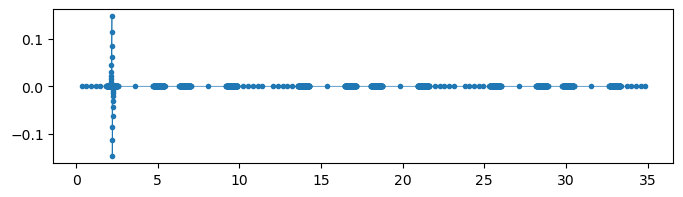

In [184]:
###################################################
# Slice lattice symmetrically around dipole edges #
###################################################

line_sliced = line.copy()

# Evenly spaced around dipole edges. Cancellations play a role, 
# so symmetry is important - we don't want to include a net dipole field!
ns = 101
s_to_slice = np.array([[np.linspace(dc - l_magn/2 - 5*gap, dc - l_magn/2 + 5*gap, ns) for dc in dipole_centers], 
                       [np.linspace(dc + l_magn/2 - 5*gap, dc + l_magn/2 + 5*gap, ns) for dc in dipole_centers], 
                       ]).flatten()
s_to_slice = np.append(s_to_slice, ([dc - l_magn*i for dc in dipole_centers[::2] for i in np.linspace(0.75, 1.15, 5)], 
                                    [dc + l_magn*i for dc in dipole_centers[1::2] for i in np.linspace(0.75, 1.15, 5)]))
s_to_slice = np.sort(np.append(s_to_slice, dipole_centers))

line_sliced.cut_at_s(s_to_slice)
tw = line_sliced.twiss4d(at_s = s_to_slice)

# Inspect points around first dipole
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(tw.s, b1_pert_ring(tw.s), marker='.', linewidth=0.5)



In [185]:
line_kicks = line.copy()
n_kicks = 10
edge = dipole_centers[0] - l_magn/2
pos_kicks = np.linspace(edge-5*gap, edge+5*gap, n_kicks)
len_kicks = pos_kicks[1] - pos_kicks[0]

for i, ss in enumerate(pos_kicks):
    line_kicks.insert_element(f"kick_{i}", xt.Multipole(knl=[b1_pert_ring([ss])*len_kicks]), at_s=ss)

Slicing line: 100%|██████████| 105/105 [00:00<00:00, 135092.61it/s]


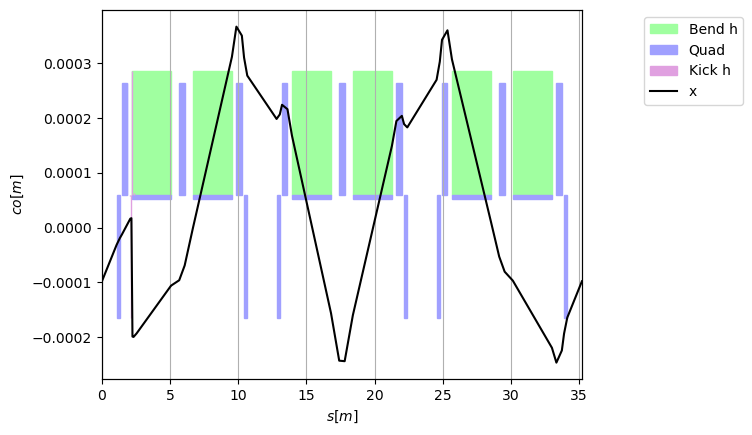

In [186]:
tw_kicks = line_kicks.twiss4d()
tw_kicks.plot("x")

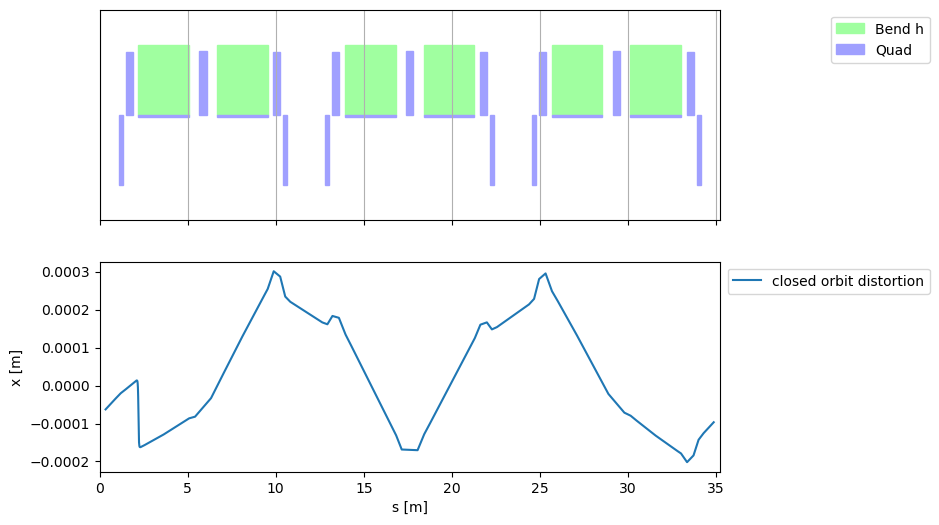

In [187]:
################################
# Plot closed orbit distortion #
################################

fig, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
tw0.plot('', figure=fig, ax=ax[0])
ax[1].plot(tw.s, deltax(tw.s, tw.mux, tw.muy, tw.betx, tw).real, label='closed orbit distortion')
ax[0].set_xlabel('')
ax[0].set_ylabel('magnets')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('x [m]')
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')


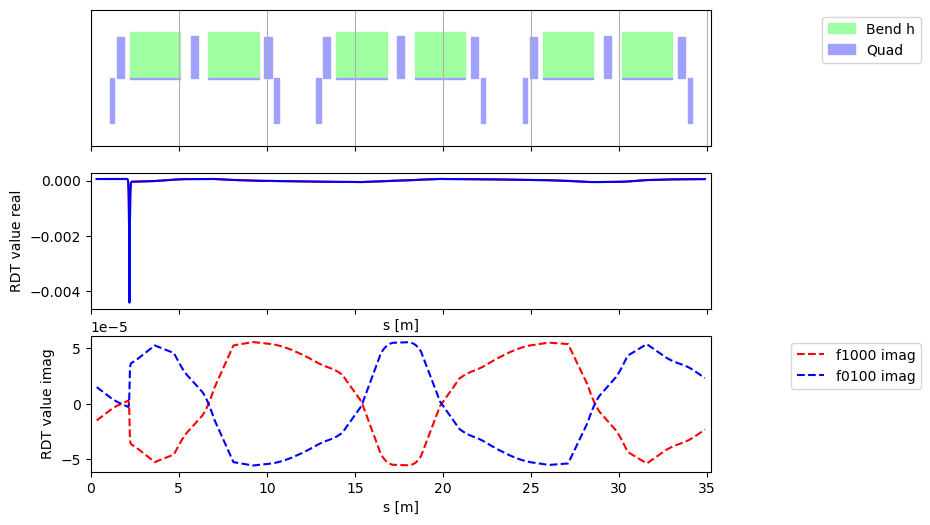

In [188]:
#####################################################
# Plot RDTs responsible for closed orbit distortion #
#####################################################

fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)
tw0.plot('', figure=fig, ax=ax[0])
ax[1].plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 real", color="red")
ax[2].plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 imag", color="red", ls='--')
ax[1].plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f0100 real", color="blue")
ax[2].plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f0100 imag", color="blue", ls='--')
ax[0].set_xlabel('')
ax[0].set_ylabel('magnets')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('RDT value real')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('RDT value imag')
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')

# Compare with approximations

For an entrance map, the closed orbit distortion is given by -sec^2(theta_E) * K0 b1 g^2 / (1+delta) (~ Whang, Lee).
From tracking, we expect this value to be negative for the entrance.
This implies that K0 b1 g^2 should be a positive value.
K0 b1 g^2 = 0.0001840633864691505


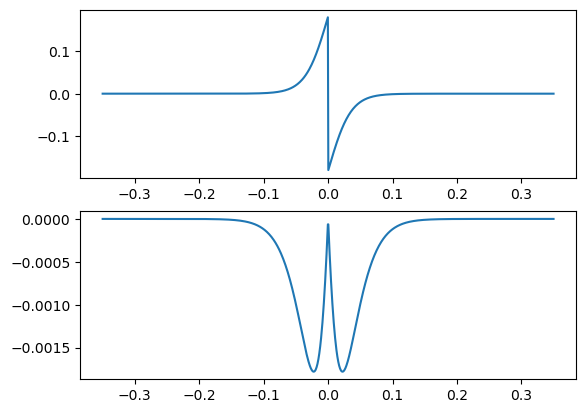

In [189]:
ss = np.linspace(-5*gap, 5*gap, 1000)
K0b1gg = np.trapezoid(-b1_pert_magnet(-l_magn/2+ss) * ss, ss)  # B0 theta(s) s - Bz(s) s
fig, ax = plt.subplots(2)
ax[0].plot(ss, b1_pert_magnet(-l_magn/2+ss))
ax[1].plot(ss, b1_pert_magnet(-l_magn/2+ss)*ss)
print("For an entrance map, the closed orbit distortion is given by -sec^2(theta_E) * K0 b1 g^2 / (1+delta) (~ Whang, Lee).")
print("From tracking, we expect this value to be negative for the entrance.")
print("This implies that K0 b1 g^2 should be a positive value.")
print("K0 b1 g^2 =", K0b1gg)

In [190]:
tw.s[np.isclose(tw.s, (dc0 - l_magn/2))]

array([2.2])

In [191]:
s0 = dc0 - l_magn/2
betx0 = tw.betx[np.isclose(tw.s, s0)]
alfx0 = tw.alfx[np.isclose(tw.s, s0)]

In [192]:
# Sign of i flipped matches better, I don't know why yet. 
h1000_lieops = -K0b1gg / (2*np.sqrt(betx0)) * (alfx0 + 1j)
h0100_lieops = -K0b1gg / (2*np.sqrt(betx0)) * (alfx0 - 1j)
width=gap/10

def h_lieops_func(p, q, r, t, s, alphx, alphy, betx, bety):
    if p==1 and q==0 and r==0 and t==0:
        return h1000_lieops * (heaviside_tol(s - (s0 - width/2)) - heaviside_tol(s - (s0 + width/2))) * 1/width
    if p==0 and q==1 and r==0 and t==0:
        return h0100_lieops * (heaviside_tol(s - (s0 - width/2)) - heaviside_tol(s - (s0 + width/2))) * 1/width

(-0.0001, 0.0001)

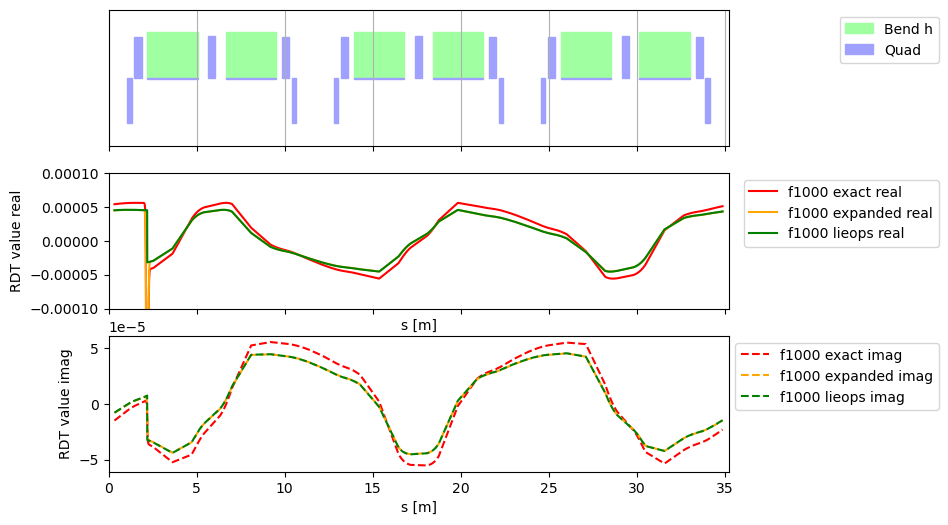

In [193]:
def h_exact_func(p, q, r, t, s, alphx, alphy, betx, bety):
    if p==1 and q==0 and r==0 and t==0:
        return -b1_pert_ring(s) * (np.sqrt(betx)/2 )
    
def h_exp_func(p, q, r, t, s, alphx, alphy, betx, bety):  # Expand h_exact around s0, keep exponent from f exact
    if p==1 and q==0 and r==0 and t==0:
#        return np.where(b1_pert_ring(s) == 0, 0, -b1_pert_ring(s) * 1/2*(np.sqrt(betx0 - 2* alfx0*(s-s0))))  # betx = betx0 - 2 alfx0 (s-s0)
#        return np.where(b1_pert_ring(s) == 0, 0, -b1_pert_ring(s) * 1/2*( np.sqrt(betx0) - alfx0*(s-s0)/np.sqrt(betx0) )) 
#        return np.where(b1_pert_ring(s) == 0, 0, -b1_pert_ring(s) * 1/2*np.sqrt(betx0) + b1_pert_ring(s) * 1/2 * alfx0*(s-s0)/np.sqrt(betx0) ) 
#        width=gap/5
        return np.where(b1_pert_ring(s) == 0, 0, -b1_pert_ring(s) * 1/2*np.sqrt(betx0) 
                        - K0b1gg * 1/2 * alfx0/np.sqrt(betx0) * (heaviside_tol(s - (dc0 - l_magn/2 - width/2)) - heaviside_tol(s - (dc0 - l_magn/2 + width/2))) * 1/width ) 
    
    
fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)
tw0.plot('', figure=fig, ax=ax[0])
ax[1].plot(tw.s, f(h_exact_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 exact real", color="red")
ax[2].plot(tw.s, f(h_exact_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 exact imag", color="red", ls='--')
ax[1].plot(tw.s, f(h_exp_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 expanded real", color="orange")
ax[2].plot(tw.s, f(h_exp_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 expanded imag", color="orange", ls='--')
ax[1].plot(tw.s, f(h_lieops_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 lieops real", color="green")
ax[2].plot(tw.s, f(h_lieops_func, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 lieops imag", color="green", ls='--')

ax[0].set_xlabel('')
ax[0].set_ylabel('magnets')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('RDT value real')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('RDT value imag')
ax[1].legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax[2].legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax[1].set_ylim(-0.0001, 0.0001)